<a href="https://colab.research.google.com/github/Rushi-Varmora/Forecasting-of-India-s-Merchandise-Exports-using-time-series-forecasting-models-/blob/main/TSA_Project(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsforecast statsmodels

**Data Description**


*   **Date** - 04/1997 to 03/2024
*   **Exports_oil** - Export of crude oil in Million USD
*   **Exports_non_oil** - Export of non oil commodities in Million USD
*   **Imports_oil** -  Import of crude oil in Million USD
*   **Imports_Non_Oil** - Import of non oil commodities in Million USD
*   **Inflation**	- Cost Inflation Index (CII) <font color="pink">[Jan 2013 to Mar 2024]</font>
*   **NEER**	- Nominal Effective Exchange Rate (NEER), an index of the weighted average of bilateral exchange rates of home currency with respect to a basket of currencies of trading partners. <font color="pink">[Jan 2013 to Mar 2024]</font>
*   **REER** - NEER adjusted by inflation differentials between the domestic currency and that of the trading partners <font color="pink">[Jan 2013 to Mar 2024]</font>






#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss,grangercausalitytests, acf,pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.base import datetools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsforecast import StatsForecast
from statsmodels.tsa.arima.model import ARIMA as sm_arima
from statsforecast.models import ARIMA as sf_arima, SeasonalNaive, AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import StandardScaler

#Loading Dataset

In [ ]:
#loading the dataset
df=pd.read_csv("/content/dataset_tsa_project.csv")
df.head()

,Date,Exports_Oil,Exports_Non_Oil,Imports_Oil,Imports_Non_Oil,inflation,NEER,REER
0,01-03-2024 00:00,5415.881121,36286.94990,17228.71922,40047.81078,185.8,94.57,101.66
1,01-02-2024 00:00,8215.957443,33189.92489,16891.03797,43221.87153,185.8,94.40,102.05
2,01-01-2024 00:00,8614.796069,28709.32962,15525.60481,37821.40090,185.5,93.21,101.24
3,01-12-2023 00:00,6888.757908,31502.27131,14940.56769,41519.78472,185.7,92.75,101.08
4,01-11-2023 00:00,7390.028718,26355.92209,14934.79209,39550.95358,186.3,93.20,102.16


# Data preprocessing and EDA

In [ ]:
# As data is in reverse chronology (recent data first), reversing the series for chronological order
df = df.loc[::-1]
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

In [ ]:
# creating a working copy of dataframe to prevent algorithm specific modifications in actual dataframe
data = df.copy()

In [ ]:
# Converting Date to required format and setting it as data frame index
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')
data.set_index('Date', inplace=True)

In [ ]:
data.head()

,Exports_Oil,Exports_Non_Oil,Imports_Oil,Imports_Non_Oil,inflation,NEER,REER
Date,,,,,,,
1997-04-01,44.9,2590.0,721.8,2458.0,NaN,NaN,NaN
1997-05-01,54.6,2990.1,740.6,2762.6,NaN,NaN,NaN
1997-06-01,22.4,2802.4,709.1,2637.4,NaN,NaN,NaN
1997-07-01,34.3,2953.2,640.5,2912.9,NaN,NaN,NaN
1997-08-01,40.7,2778.1,695.6,2364.1,NaN,NaN,NaN


NOTE:


*   Here as the base year for inflation is 2012, we have used data for these values from Jan-2013.
*   Data for currency exchange rates(NEER & REER) is also considered from Jan-2013.




In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1997-04-01 to 2024-03-01
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Exports_Oil      324 non-null    float64
 1   Exports_Non_Oil  324 non-null    float64
 2   Imports_Oil      324 non-null    float64
 3   Imports_Non_Oil  324 non-null    float64
 4   inflation        135 non-null    float64
 5   NEER             134 non-null    float64
 6   REER             134 non-null    float64
dtypes: float64(7)
memory usage: 20.2 KB


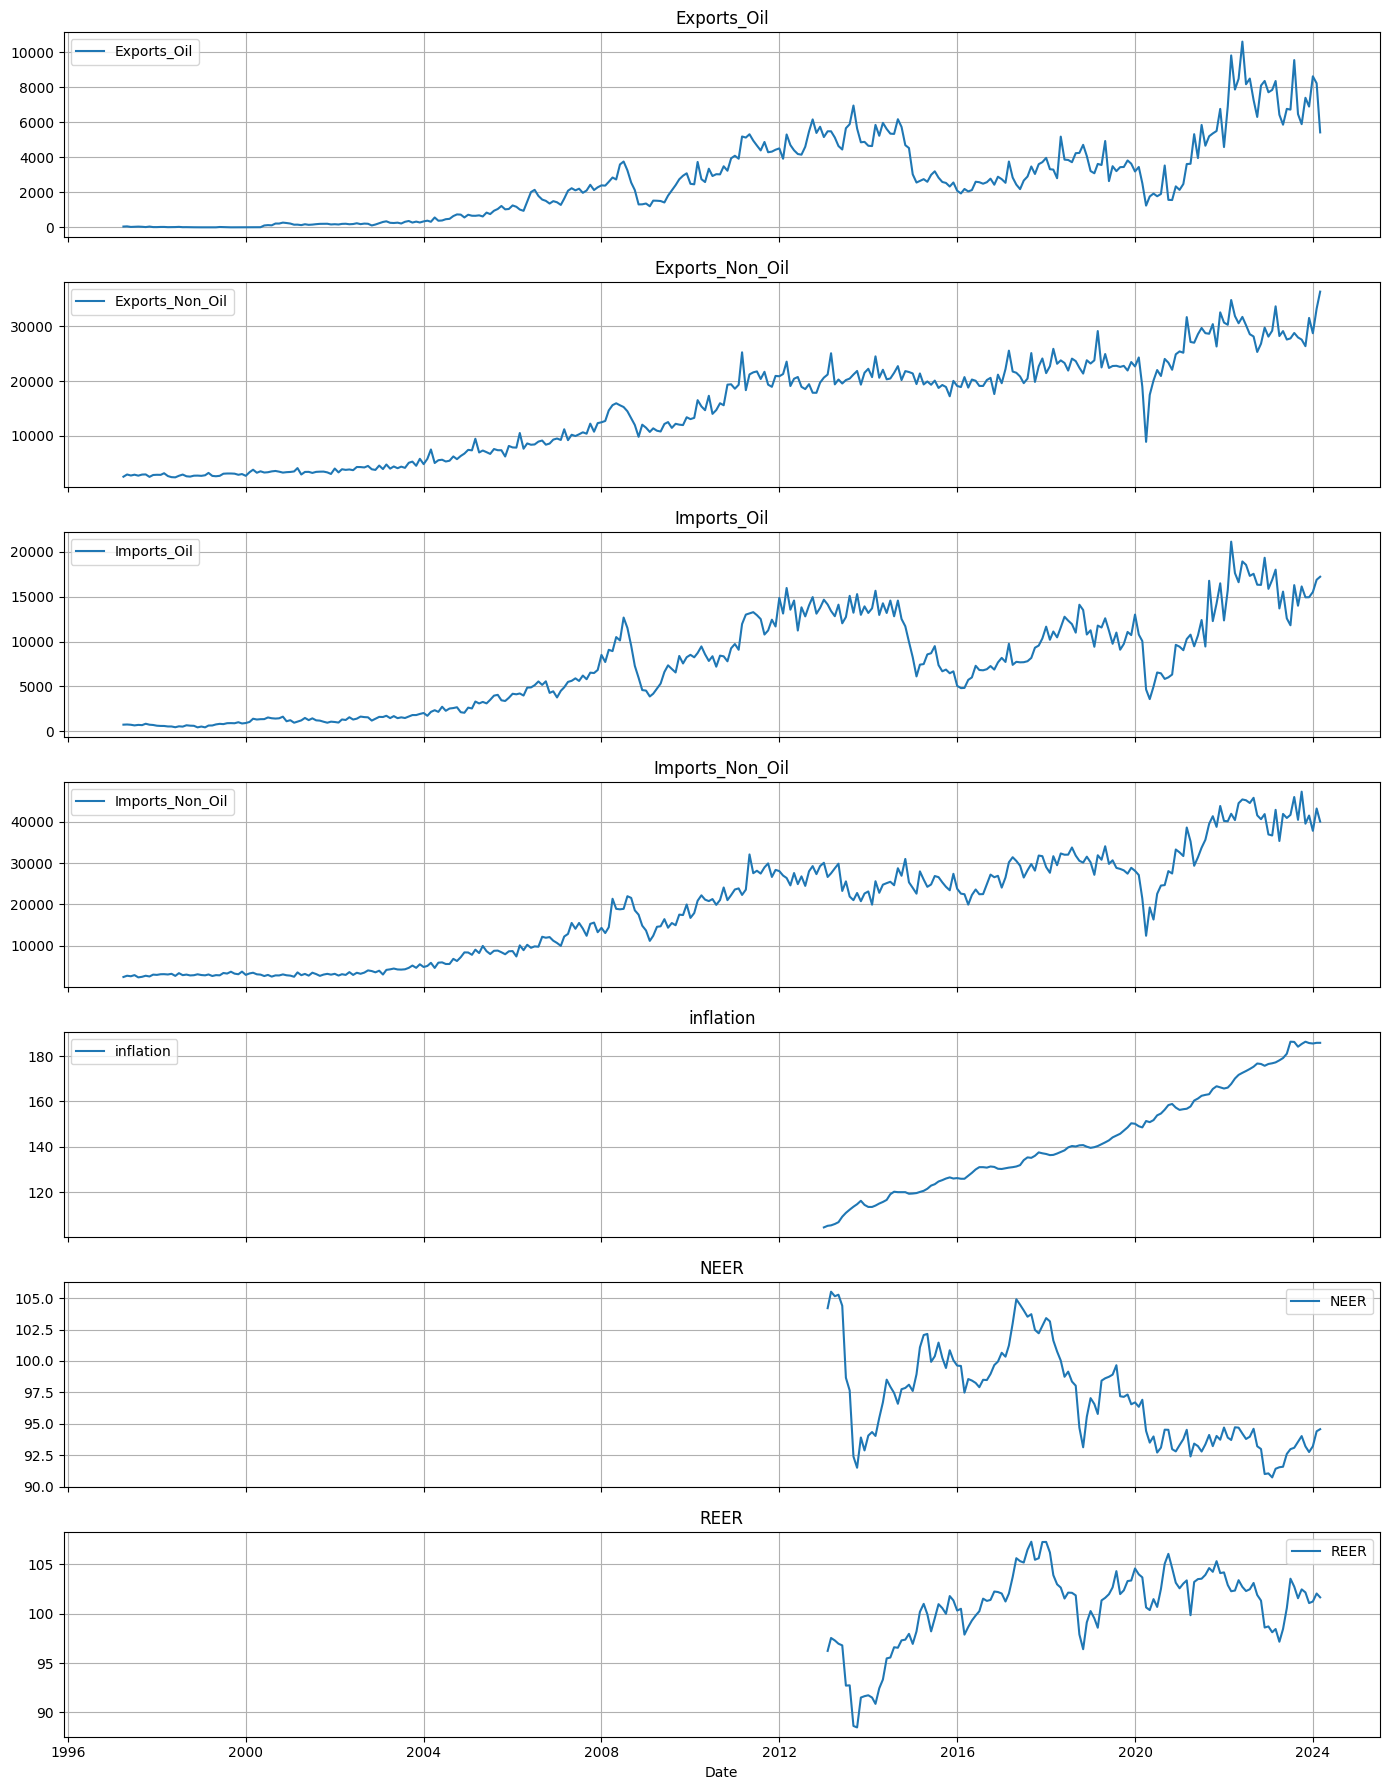

In [ ]:
# Plotting each column in a separate subplot
fig, axes = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(14, 18), sharex=True)

for ax, column in zip(axes, data.columns):
    ax.plot(data.index, data[column], label=column)
    ax.set_title(column)
    ax.legend()
    ax.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

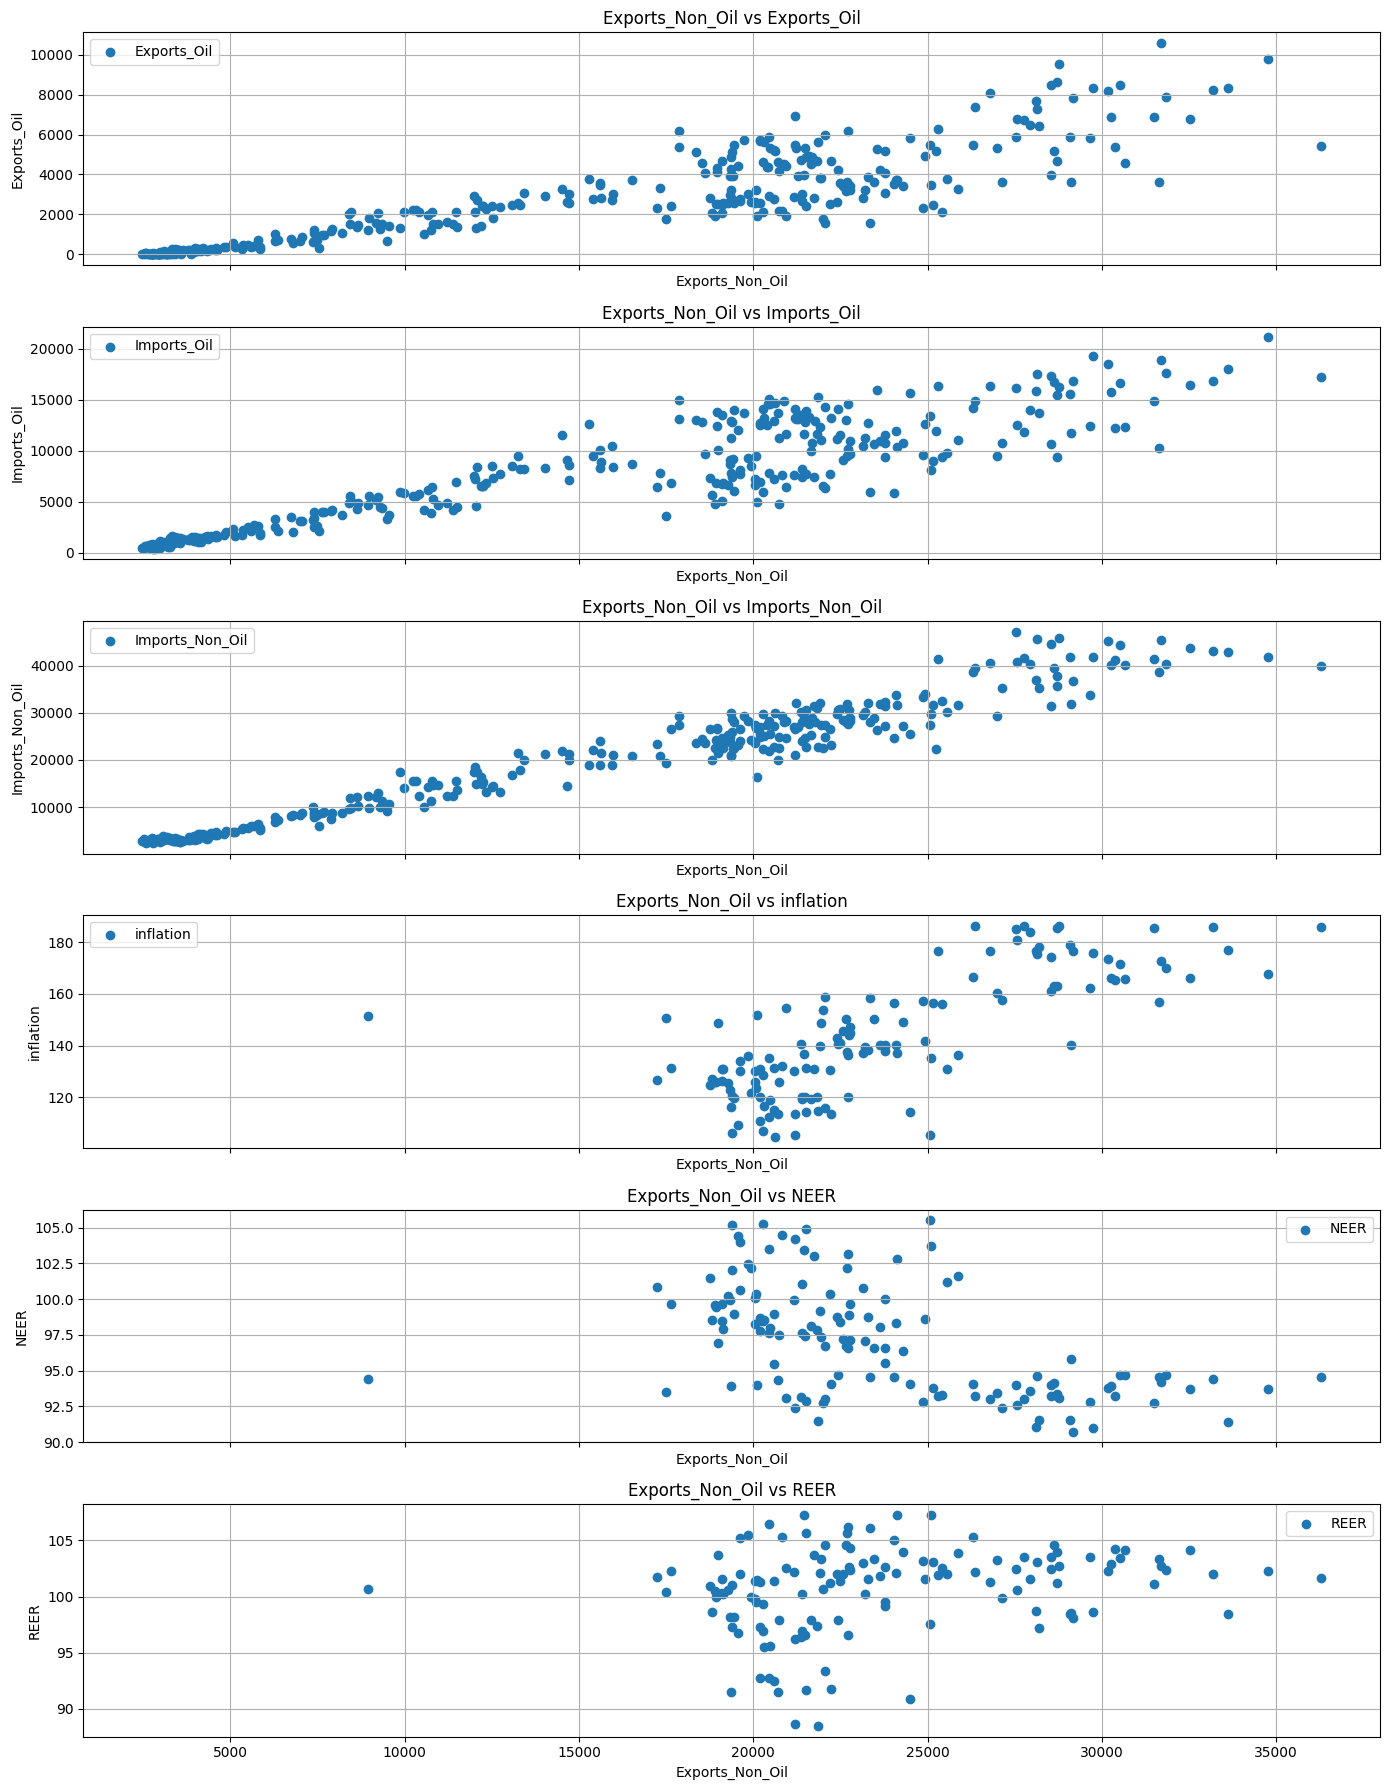

In [ ]:
# Plot scatter plots of each column against 'Exports_Non_Oil'
plot_with_columns = [col for col in data.columns if col !="Exports_Non_Oil"]
fig, axes = plt.subplots(nrows=len(plot_with_columns) , ncols=1, figsize=(14, 18), sharex=True)

for ax, column in zip(axes, plot_with_columns):
    if column != 'Exports_Non_Oil':
        ax.scatter(data['Exports_Non_Oil'], data[column], label=column)
        ax.set_title(f'Exports_Non_Oil vs {column}')
        ax.set_xlabel('Exports_Non_Oil')
        ax.set_ylabel(column)
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

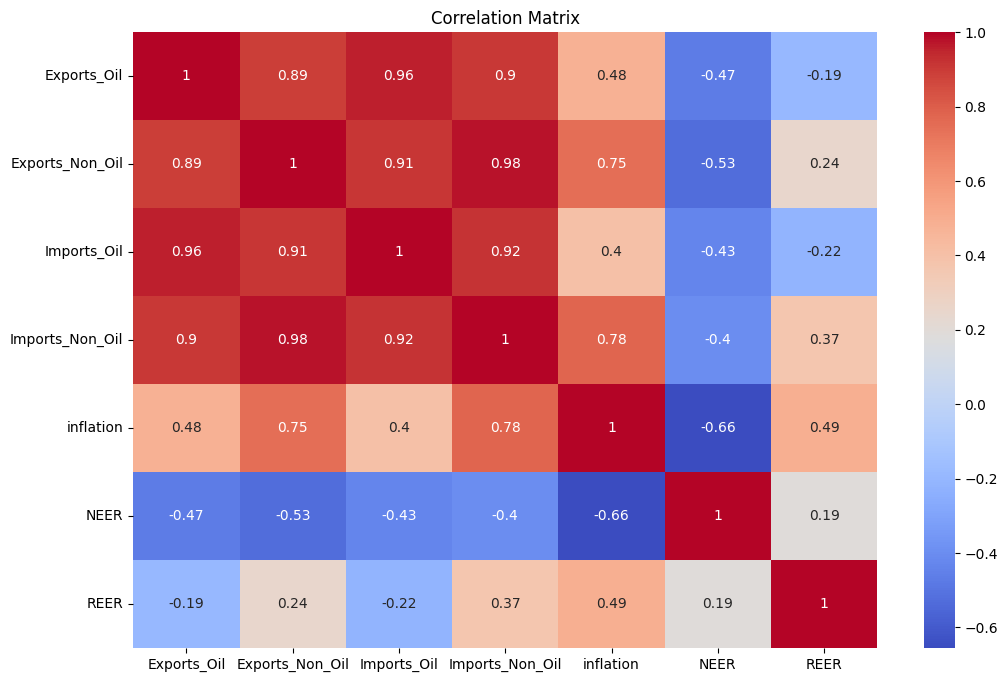

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = data[['Exports_Oil', 'Exports_Non_Oil', 'Imports_Oil', 'Imports_Non_Oil','inflation','NEER','REER']].astype(float).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#Dicky-Fuller Test
To check stationarity of the series

In [ ]:
# Check for stationarity of 'Exports_Non_Oil'
result = adfuller(data['Exports_Non_Oil'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("Critical value alpha : 0.05")
print("Series is not stationary") if result[1] > 0.05 else print("Series is stationary")

ADF Statistic: -0.186619
p-value: 0.940098
Critical value alpha : 0.05
Series is not stationary


In [ ]:
# If not stationary, apply differencing
data_diff = data['Exports_Non_Oil'].diff().dropna()
result = adfuller(data_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("Critical value alpha : 0.05")
print("Series is not stationary") if result[1] > 0.05 else print("Series is stationary")
print("As Series becomes stationary after single difference,\nhence d=1")

ADF Statistic: -5.093601
p-value: 0.000014
Critical value alpha : 0.05
Series is stationary
As Series becomes stationary after single difference,
hence d=1


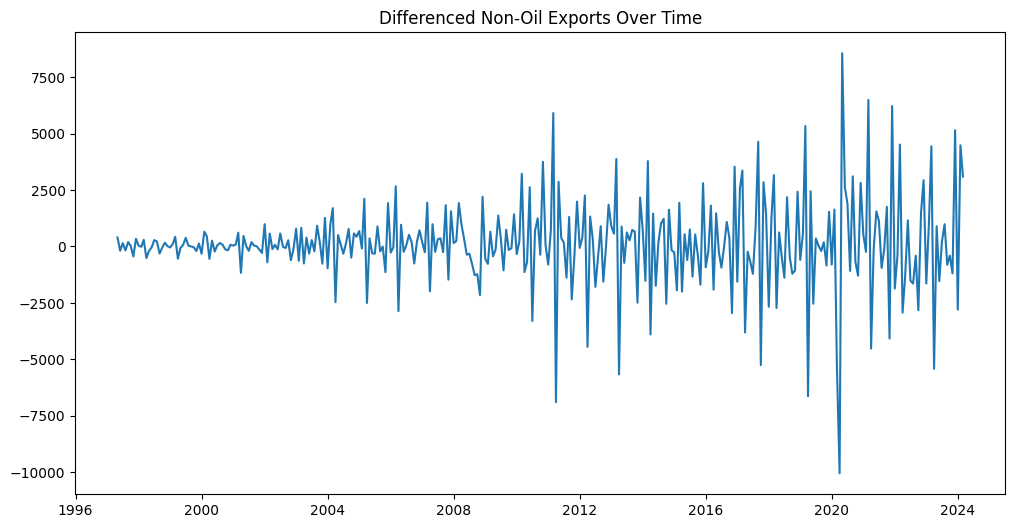

In [ ]:
# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(data_diff)
plt.title('Differenced Non-Oil Exports Over Time')
plt.show()

# Univariate Forecasting

##1. ARIMA

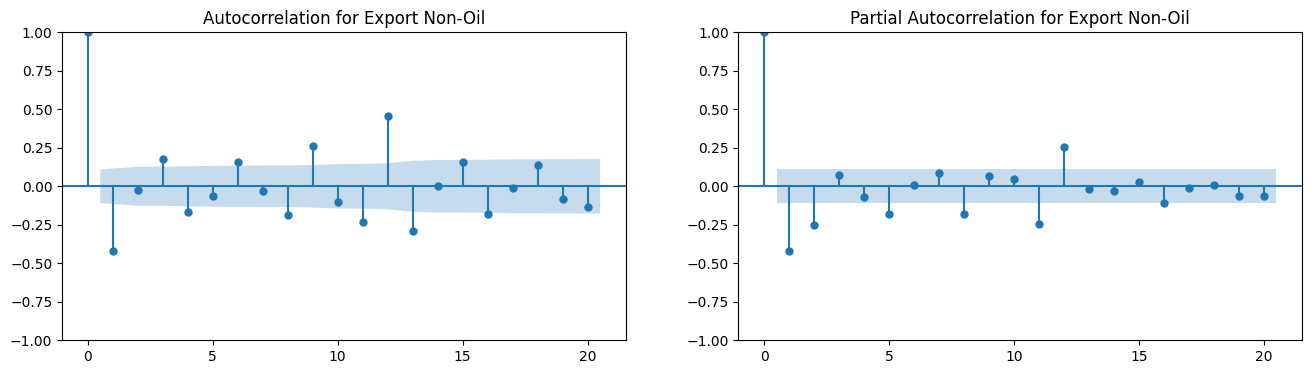

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'data_diff' is your differenced time series data
# Replace 'data_diff' with your actual data variable

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(data_diff, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation for Export Non-Oil')

# Plot PACF
plot_pacf(data_diff, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation for Export Non-Oil')

plt.show()

In [ ]:
uni_result_df= pd.DataFrame(columns=['Model','MAE','MAPE'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        Exports_Non_Oil   No. Observations:                  312
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2749.307
Date:                Fri, 21 Jun 2024   AIC                           5506.613
Time:                        06:49:15   BIC                           5521.573
Sample:                    04-01-1997   HQIC                          5512.593
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7504      0.149     -5.026      0.000      -1.043      -0.458
ar.L2         -0.3633      0.069     -5.240      0.000      -0.499      -0.227
ma.L1          0.2355      0.162      1.457      0.1

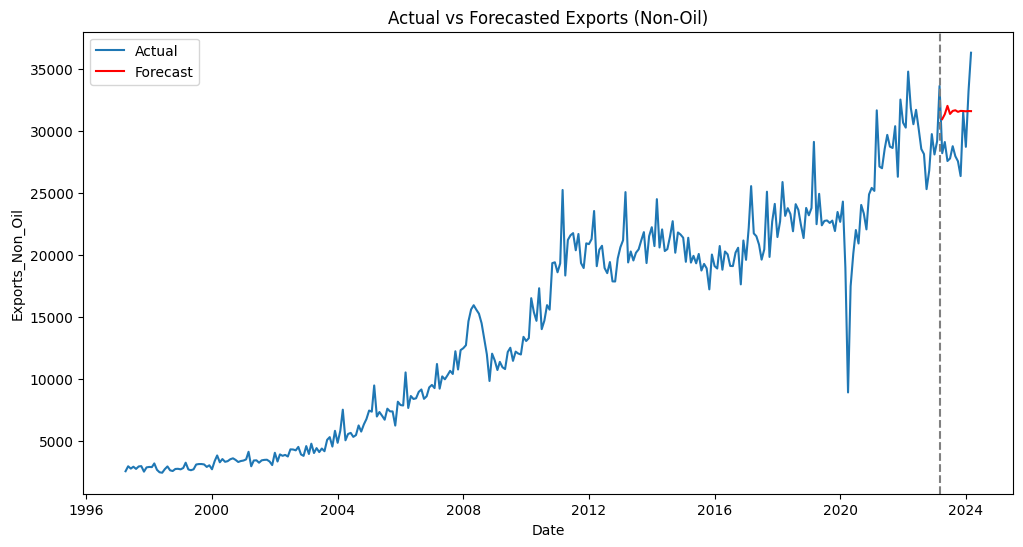

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Split the data into training and testing sets
train_size = len(data) - 12
train_data = data['Exports_Non_Oil'][:train_size]
test_data = data['Exports_Non_Oil'][train_size:]

# Fit the ARIMA model on the training data
model = ARIMA(train_data, order=(2, 1, 1))
fitted_model = model.fit()

print(fitted_model.summary())

# Forecast the next 12 periods
forecast = fitted_model.forecast(steps=12)

# Calculate the residuals
residuals = train_data - fitted_model.fittedvalues
residuals.dropna(inplace=True)

# Calculate MAE and MAPE
mae_arima = mean_absolute_error(test_data, forecast)
mape_arima = mean_absolute_percentage_error(test_data, forecast)

print(f'Mean Absolute Error (MAE): {mae_arima:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_arima:.4f}')

# Assuming uni_result_df is a DataFrame to store results
uni_result_df.loc[len(uni_result_df)] = ['ARIMA', mae_arima, mape_arima]

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Exports_Non_Oil'], label='Actual')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.axvline(x=train_data.index[-1], color='gray', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Exports_Non_Oil')
plt.title('Actual vs Forecasted Exports (Non-Oil)')
plt.legend()
plt.show()

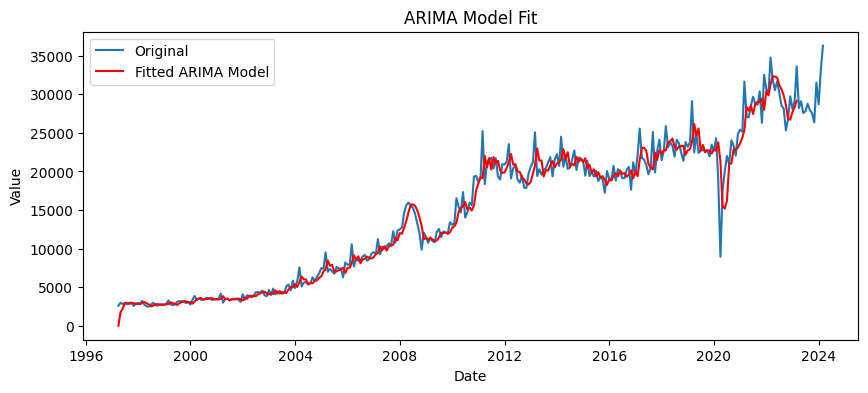

In [ ]:
# Plot the fitted ARIMA model
plt.figure(figsize=(10, 4))
plt.plot(data['Exports_Non_Oil'], label='Original')
plt.plot(fitted_model.fittedvalues, label='Fitted ARIMA Model', color='red')
plt.title('ARIMA Model Fit')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

##2. AutoArima

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


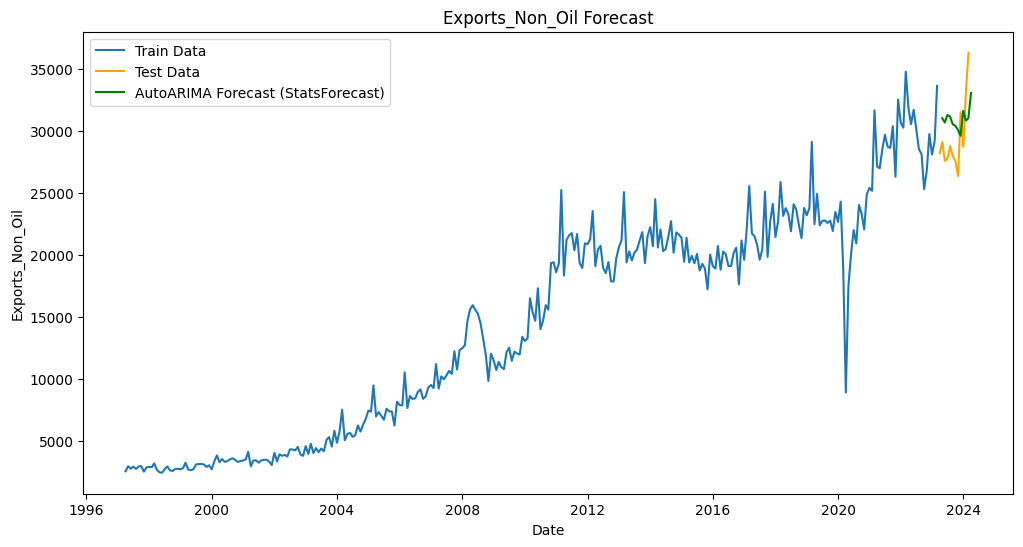

Mean Absolute Error (MAE): 2425.356776927083
Mean Absolute Percentage Error (MAPE): 0.08382642634757426


In [ ]:
# Split the data into train and test sets (last year as test set)
train_data = data.iloc[:-12]
test_data = data.iloc[-12:]

# Prepare train data
train_statsforecast = train_data[['Exports_Non_Oil']].reset_index()
train_statsforecast.columns = ['ds', 'y']
train_statsforecast['unique_id'] = 1  # Adding a dummy unique_id column

# Initialize the model
auto_arima_model = AutoARIMA(season_length=12)

# Initialize StatsForecast
sf = StatsForecast(models=[auto_arima_model], freq='M')

# Fit the model and make forecast
sf.fit(train_statsforecast)
arima_forecast_stats = sf.predict(12)

# Convert the forecasted values to a pandas Series for plotting
forecast_dates = pd.date_range(start=train_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
arima_forecast_series = pd.Series(arima_forecast_stats['AutoARIMA'].values.flatten(), index=forecast_dates)

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data['Exports_Non_Oil'], label='Train Data')
plt.plot(test_data['Exports_Non_Oil'], label='Test Data', color='orange')
plt.plot(arima_forecast_series, label='AutoARIMA Forecast (StatsForecast)', color='green')
plt.title('Exports_Non_Oil Forecast')
plt.xlabel('Date')
plt.ylabel('Exports_Non_Oil')
plt.legend()
plt.show()

# Evaluate the model on the test set
# Calculate MAE and MAPE
autoarima_mae = mean_absolute_error(test_data['Exports_Non_Oil'], arima_forecast_series)
autoarima_mape = mean_absolute_percentage_error(test_data['Exports_Non_Oil'], arima_forecast_series)

print("Mean Absolute Error (MAE):", autoarima_mae)
print("Mean Absolute Percentage Error (MAPE):", autoarima_mape)

uni_result_df.loc[len(uni_result_df)] = ['AutoARIMA', autoarima_mae, autoarima_mape]


In [ ]:
#Optimal model parameter selected by AutoArima
sf.fitted_[0][0].model_["arma"]

(0, 1, 2, 0, 12, 1, 0)

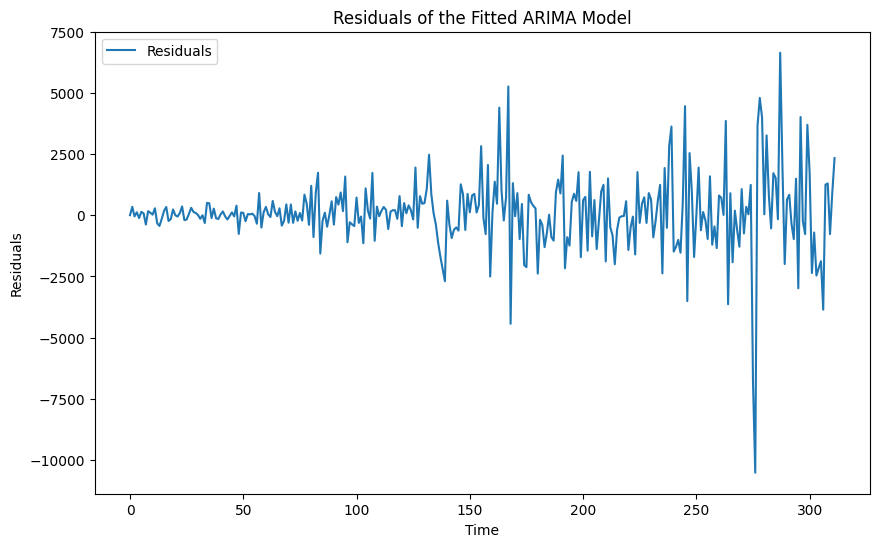

In [ ]:
#Residual plots
residuals_autoarima = sf.fitted_[0][0].model_["residuals"]

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_autoarima, label='Residuals')
plt.title('Residuals of the Fitted ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


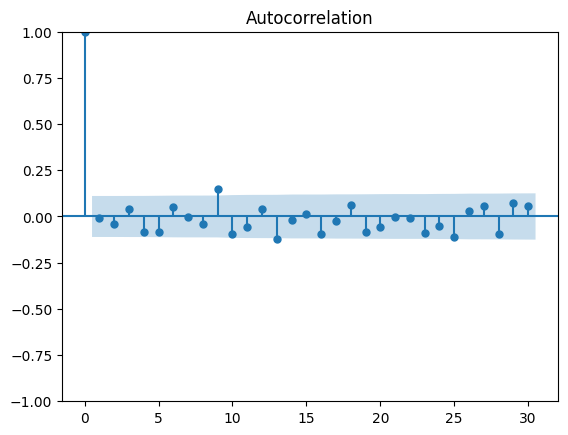

In [ ]:
#Residual ACF
plot_acf(residuals_autoarima, lags=30)
plt.show()

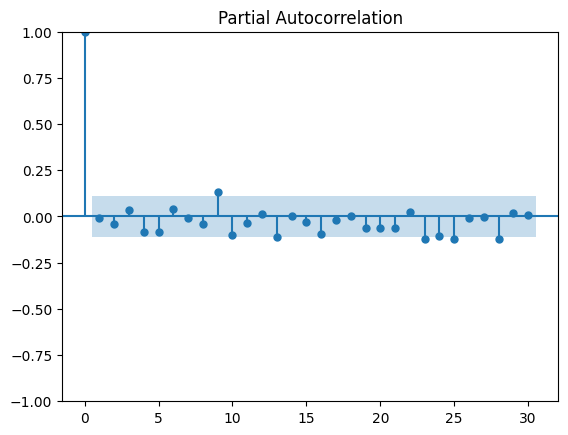

In [ ]:
#Residual PACF
plot_pacf(residuals_autoarima, lags=30)
plt.show()

**<font color='pink'>From Residual analysis we can confirm that Residual is white Noise and hence model has covered all the relevant patterns.<font>**

##3. Prophet - Univarient

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pbufg5z/a9hnb7li.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pbufg5z/71pbzswe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6516', 'data', 'file=/tmp/tmp6pbufg5z/a9hnb7li.json', 'init=/tmp/tmp6pbufg5z/71pbzswe.json', 'output', 'file=/tmp/tmp6pbufg5z/prophet_model9184jk7g/prophet_model-20240621064948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:49:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


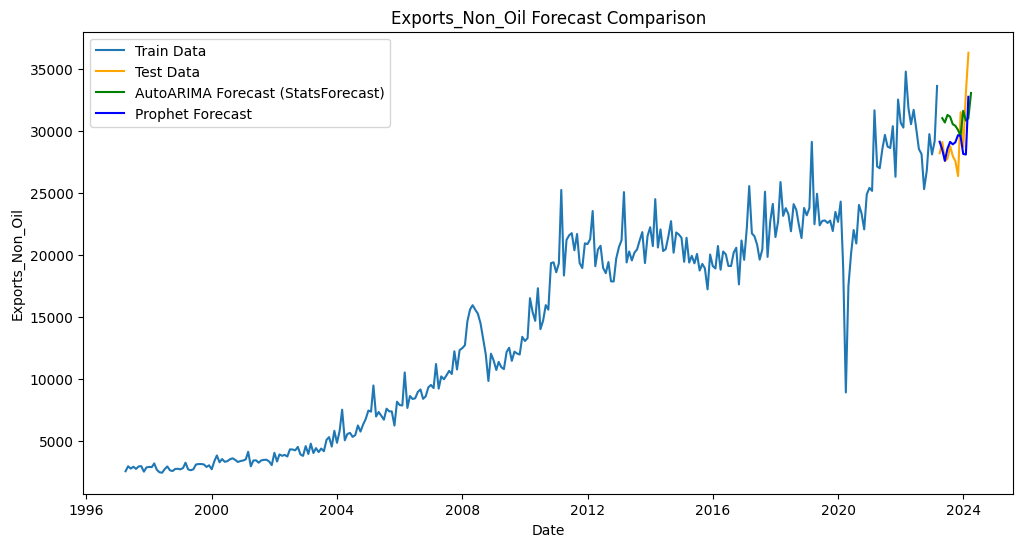

Prophet Mean Absolute Error (MAE): 1633.0015309848575
Prophet Mean Absolute Percentage Error (MAPE): 0.05345472771981494


In [ ]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = data.reset_index()[['Date', 'Exports_Non_Oil']]
prophet_data.columns = ['ds', 'y']

# Initialize and fit Prophet model on train data
train_prophet_data = prophet_data.iloc[:-12]
prophet_model = Prophet()
prophet_model.fit(train_prophet_data)

# Make future dataframe and forecast
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Extract the forecasted values
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds').iloc[-12:]

# Evaluate the model on the test set
mae_prophet = mean_absolute_error(test_data['Exports_Non_Oil'], prophet_forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(test_data['Exports_Non_Oil'], prophet_forecast['yhat'])

uni_result_df.loc[len(uni_result_df)] = ['Prophet', mae_prophet, mape_prophet]

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data['Exports_Non_Oil'], label='Train Data')
plt.plot(test_data['Exports_Non_Oil'], label='Test Data', color='orange')
plt.plot(arima_forecast_series, label='AutoARIMA Forecast (StatsForecast)', color='green')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Forecast', color='blue')
plt.title('Exports_Non_Oil Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Exports_Non_Oil')
plt.legend()
plt.show()

print("Prophet Mean Absolute Error (MAE):", mae_prophet)
print("Prophet Mean Absolute Percentage Error (MAPE):", mape_prophet)


#Multivariate Forecasting

In [ ]:
multi_result_df= pd.DataFrame(columns=['Model','MAE','MAPE'])

In [ ]:
datacopy = data.copy()

In [ ]:
# Taking the data from Jan-2013 for multivariate analysis
datacopy = datacopy.iloc[190:]

##1. VAR

In [ ]:
'''
Function to check stationarity of the series
input: series
output: p-value
'''
def check_stationarity(series):
    result = adfuller(series)
    return result[1]

'''
Function to apply differencing if needed
input: series
output: differenced series
'''
def difference(series):
    return series.diff().dropna()

In [ ]:

test_data.head()

,Exports_Oil,Exports_Non_Oil,Imports_Oil,Imports_Non_Oil,inflation,NEER,REER
Date,,,,,,,
2023-04-01,6420.561599,28197.88805,13693.79461,35362.31234,178.1,91.54,97.16
2023-05-01,5854.366904,29098.10854,15574.12206,41907.30230,179.1,91.58,98.45
2023-06-01,6757.101224,27566.89054,12582.17209,40931.05956,181.0,92.60,100.57
2023-07-01,6715.726850,27773.69090,11812.53245,41678.27884,186.3,92.98,103.55
2023-08-01,9541.091060,28761.16937,16293.00624,46005.83395,186.2,93.09,102.75


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


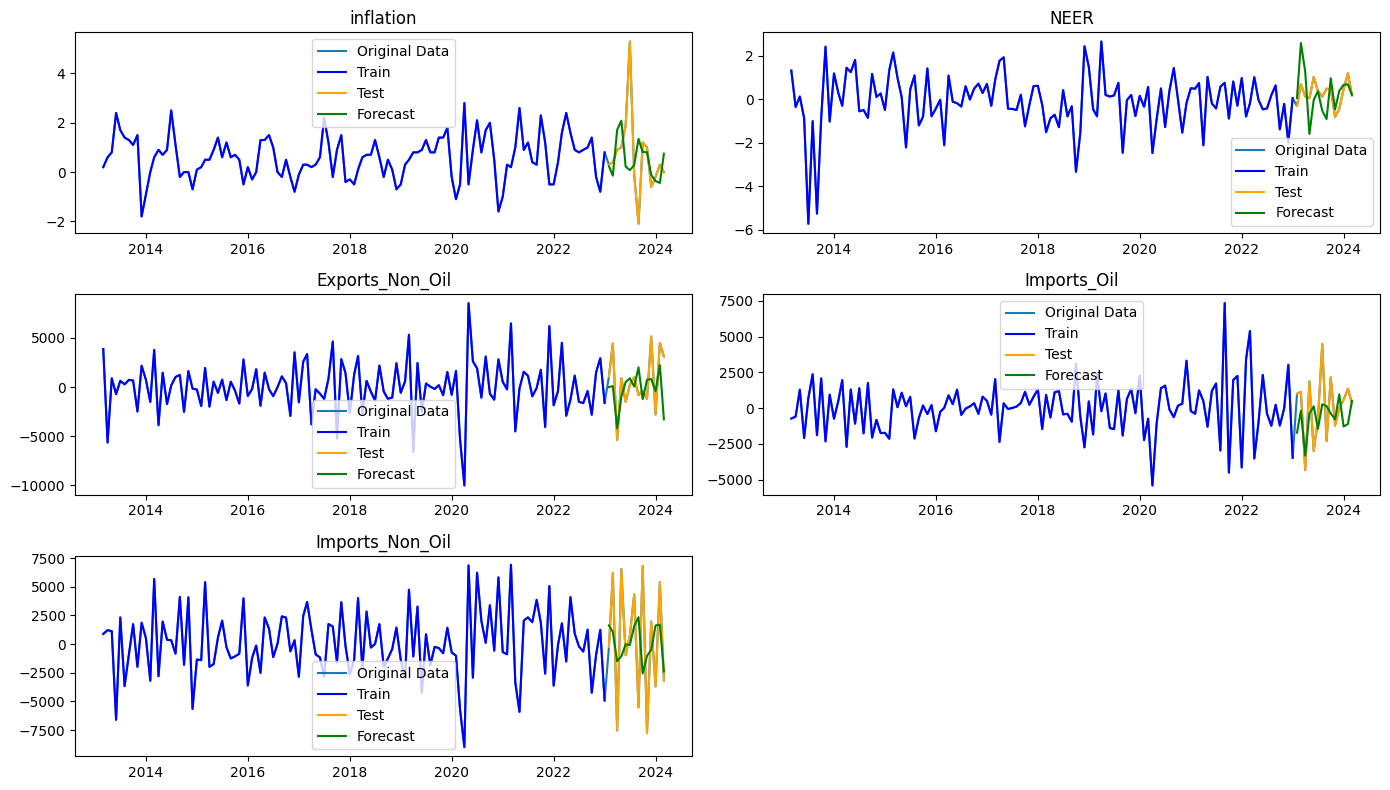


RMSE Values:
 {'inflation': 1.8089943066639613, 'NEER': 0.9462601333113442, 'Exports_Non_Oil': 2843.860190036731, 'Imports_Oil': 2174.249920183646, 'Imports_Non_Oil': 5192.349322627873}

MAE Values:
 {'inflation': 1.13949412615274, 'NEER': 0.7556245241221822, 'Exports_Non_Oil': 2364.8934359389955, 'Imports_Oil': 1870.3015639304563, 'Imports_Non_Oil': 4391.2785520474445}

MAPE Values:
 {'inflation': 1.189771730206703, 'NEER': 4.904472500340688, 'Exports_Non_Oil': 1.5251773552595826, 'Imports_Oil': 12.953454403799727, 'Imports_Non_Oil': 1.4511076036425103}


In [ ]:
pd.set_option('mode.use_inf_as_na', True)
# Ensure the index is sorted and monotonic
VAR_data = datacopy.sort_index()

# Select features for forecasting
features = VAR_data[['inflation', 'NEER', 'Exports_Non_Oil', 'Imports_Oil', 'Imports_Non_Oil']]

# Handle missing values
features = features.interpolate(method='time')

# Check and apply differencing if necessary
for col in features.columns:
    p_value = check_stationarity(features[col])
    if (p_value > 0.05):  # p-value > 0.05 indicates non-stationarity
        features[col] = difference(features[col])

# Split the data into train and test sets (last year as test set)

train = features[:int(0.9*(len(features)))]
test = features[int(0.9*(len(features))):]
train = train.iloc[1:]

# Model Training
model = VAR(train)
lag_order = model.select_order()
# Selecting optimal Lag
optimal_lag = lag_order.aic

model_fitted = model.fit(optimal_lag)

# Forecasting
forecast_steps = len(test)
forecast = model_fitted.forecast(model_fitted.endog, steps=forecast_steps)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

# Evaluate Forecast using RMSE, MAE, and MAPE
rmse_values = {}
mae_values = {}
mape_values = {}

for col in test.columns:
    rmse = np.sqrt(mean_squared_error(test[col], forecast_df[col]))
    mae = mean_absolute_error(test[col], forecast_df[col])
    mape = np.mean(np.abs((test[col] - forecast_df[col]) / test[col]))

    rmse_values[col] = rmse
    mae_values[col] = mae
    mape_values[col] = mape

# Plot the actual vs forecasted values
plt.figure(figsize=(14, 8))

for i, col in enumerate(test.columns, 1):
    plt.subplot(3, 2, i)
    plt.plot(features[col], label='Original Data')
    plt.plot(train[col], label='Train', color='blue')
    plt.plot(test[col], label='Test', color='orange')
    plt.plot(forecast_df[col], label='Forecast', color='green')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

# Print RMSE, MAE, and MAPE values
print("\nRMSE Values:\n", rmse_values)
print("\nMAE Values:\n", mae_values)
print("\nMAPE Values:\n", mape_values)

multi_result_df.loc[len(multi_result_df)] = ['VAR', mae_values['Exports_Non_Oil'], mape_values['Exports_Non_Oil']]

##Prophet with 3 series

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pbufg5z/jq893s24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pbufg5z/9fq1p1z_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26004', 'data', 'file=/tmp/tmp6pbufg5z/jq893s24.json', 'init=/tmp/tmp6pbufg5z/9fq1p1z_.json', 'output', 'file=/tmp/tmp6pbufg5z/prophet_modelw1zmg_1l/prophet_model-20240621064956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


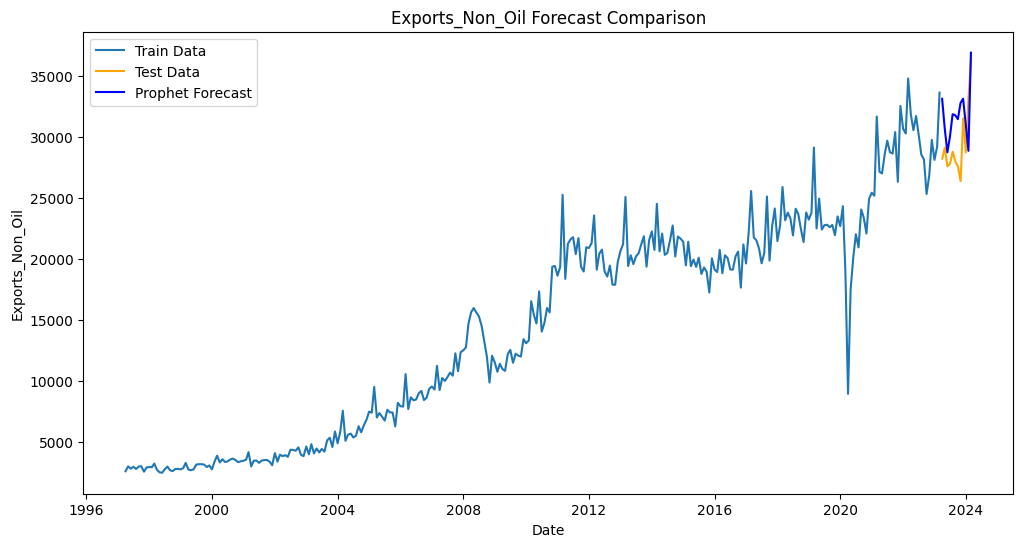

Prophet Mean Absolute Error (MAE): 2988.5824734096914
Prophet Mean Absolute Percentage Error (MAPE): 0.1045908993649055


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Prepare data for Prophet
prophet_data = datacopy.reset_index()[['Date', 'Exports_Non_Oil', 'inflation', 'REER']]
prophet_data.columns = ['ds', 'y', 'inflation', 'REER']

# Initialize the Prophet model and add the additional regressors
prophet_model = Prophet()
prophet_model.add_regressor('inflation')
prophet_model.add_regressor('REER')

# Train the model on the training data
train_prophet_data = prophet_data.iloc[:-12]
prophet_model.fit(train_prophet_data)

# Make future dataframe and include the future values of the regressors
future = prophet_model.make_future_dataframe(periods=12, freq='M')
future['inflation'] = prophet_data['inflation']
future['REER'] = prophet_data['REER']

# Forecast the future values
forecast = prophet_model.predict(future)

# Extract the forecasted values
prophet_forecast_3 = forecast[['ds', 'yhat']].set_index('ds').iloc[-12:]

# Evaluate the model on the test set
mae_prophet_3 = mean_absolute_error(test_data['Exports_Non_Oil'], prophet_forecast_3['yhat'])
mape_prophet_3 = mean_absolute_percentage_error(test_data['Exports_Non_Oil'], prophet_forecast_3['yhat'])

multi_result_df.loc[len(multi_result_df)] = ['Prophet_3', mae_prophet_3, mape_prophet_3]

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data['Exports_Non_Oil'], label='Train Data')
plt.plot(test_data['Exports_Non_Oil'], label='Test Data', color='orange')
plt.plot(prophet_forecast_3.index, prophet_forecast_3['yhat'], label='Prophet Forecast', color='blue')
plt.title('Exports_Non_Oil Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Exports_Non_Oil')
plt.legend()
plt.show()

print("Prophet Mean Absolute Error (MAE):", mae_prophet_3)
print("Prophet Mean Absolute Percentage Error (MAPE):", mape_prophet_3)


##Prophet with 5 Series

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pbufg5z/3io7wt5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pbufg5z/rmqu24j1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26724', 'data', 'file=/tmp/tmp6pbufg5z/3io7wt5n.json', 'init=/tmp/tmp6pbufg5z/rmqu24j1.json', 'output', 'file=/tmp/tmp6pbufg5z/prophet_modelshoe6vz_/prophet_model-20240621064957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:49:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


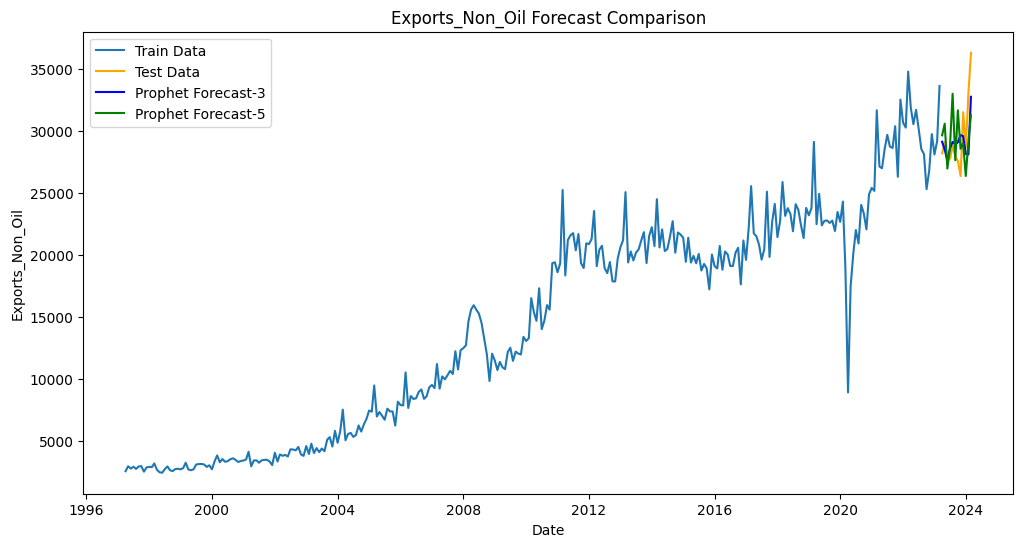

Prophet Mean Absolute Error (MAE): 2426.8827053416985
Prophet Mean Absolute Percentage Error (MAPE): 0.08052913215941238


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Prepare data for Prophet
prophet_data = datacopy.reset_index()[['Date', 'Exports_Non_Oil', 'inflation', 'NEER', 'Imports_Oil', 'Imports_Non_Oil']]
prophet_data.columns = ['ds', 'y', 'inflation', 'NEER', 'Imports_Oil', 'Imports_Non_Oil']

# Initialize the Prophet model and add the additional regressors
prophet_model = Prophet()
prophet_model.add_regressor('inflation')
prophet_model.add_regressor('NEER')
prophet_model.add_regressor('Imports_Oil')
prophet_model.add_regressor('Imports_Non_Oil')

# Train the model on the training data
train_prophet_data = prophet_data.iloc[:-12]
prophet_model.fit(train_prophet_data)

# Make future dataframe and include the future values of the regressors
future = prophet_model.make_future_dataframe(periods=12, freq='M')
future['inflation'] = prophet_data['inflation']
future['NEER'] = prophet_data['NEER']
future['Imports_Oil'] = prophet_data['Imports_Oil']
future['Imports_Non_Oil'] = prophet_data['Imports_Non_Oil']

# Forecast the future values
forecast = prophet_model.predict(future)

# Extract the forecasted values
prophet_forecast_5 = forecast[['ds', 'yhat']].set_index('ds').iloc[-12:]

# Evaluate the model on the test set
mae_prophet_2 = mean_absolute_error(test_data['Exports_Non_Oil'], prophet_forecast_5['yhat'])
mape_prophet_2 = mean_absolute_percentage_error(test_data['Exports_Non_Oil'], prophet_forecast_5['yhat'])
multi_result_df.loc[len(multi_result_df)] = ['Prophet_5', mae_prophet_2, mape_prophet_2]

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data['Exports_Non_Oil'], label='Train Data')
plt.plot(test_data['Exports_Non_Oil'], label='Test Data', color='orange')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Forecast-3', color='blue')
plt.plot(prophet_forecast_5.index, prophet_forecast_5['yhat'], label='Prophet Forecast-5', color='green')
plt.title('Exports_Non_Oil Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Exports_Non_Oil')
plt.legend()
plt.show()

print("Prophet Mean Absolute Error (MAE):", mae_prophet_2)
print("Prophet Mean Absolute Percentage Error (MAPE):", mape_prophet_2)


#Final Comparison

## Univariate Forecasting Model Performance

In [ ]:
uni_result_df

,Model,MAE,MAPE
0,ARIMA,3168.660232,0.109936
1,AutoARIMA,2425.356777,0.083826
2,Prophet,1633.001531,0.053455


## Multivariate Forecasting Model Preformance

In [ ]:
multi_result_df

,Model,MAE,MAPE
0,VAR,2364.893436,1.525177
1,Prophet_3,2988.582473,0.104591
2,Prophet_5,2426.882705,0.080529
